(generalised_filtering)=
# Generalised Bayesian Filtering

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
import seaborn as sns
from scipy.stats import norm, t
from scipy.special import gammaln
from matplotlib.ticker import MultipleLocator
from pyhgf.networks import beliefs_propagation
from pyhgf.math import SufficientStatistics
import jax.numpy as jnp
from pyhgf.model import HGF

np.random.seed(123)

Here, using the approach described in {cite:p}`weber:2020`we demonstrate how the Hierarchical Gaussian Filter can be generalized to any probability distribution that belongs to the [exponential family](https://en.wikipedia.org/wiki/Exponential_family).
Exponential families of probability distributions are those which can be written in the form:

$$
p(x|\nu) = f_x(\nu) := h(x) exp(\eta(\nu) · t(x) − b(\nu))
$$

where:
- $x$ is a vector-valued observation
- $\nu$ is a parameter vector
- $h(x)$ is a normalization constant
- $\eta(\nu)$ is the natural parameter vector
- $t(x)$ is the sufficient statistic vector
- $b(\nu)$ is a scalar function

In [2]:
x = np.arange(-15, 15, .01)

In [3]:
def gaussian_predictive_distribution(x, xi, nu):
    return (
        np.sqrt(1/(np.pi * (nu + 1) * (xi[1] - xi[0]**2)))
        * np.exp((gammaln((nu+2) / 2) - gammaln((nu + 1) / 2)))  # use gammaln to avoid numerical overflow
        * (1 + ((x-xi[0])**2) / ((nu + 1)*(xi[1]-xi[0]**2)))**(-(nu+2)/2)
    )

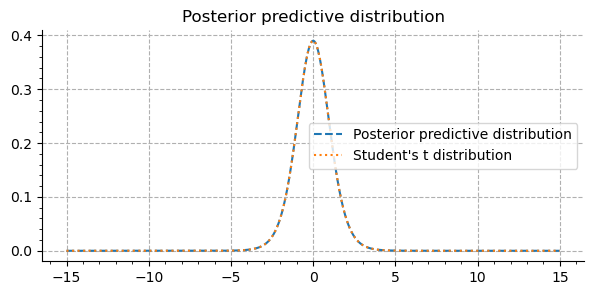

In [4]:
_, ax = plt.subplots(figsize=(7, 3))
ax.plot(
    x,
    gaussian_predictive_distribution(x, xi=np.array([0, 1]), nu=10),
    linestyle="--",
    label="Posterior predictive distribution"
)

ax.plot(
    x,
    t.pdf(x, 11),
    linestyle=":",
    label="Student's t distribution"
)
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(.02))
ax.set_title("Posterior predictive distribution")
ax.legend()
ax.grid(linestyle="--");
sns.despine()

## Filtering of Sufficient Statistics for Stationary Input Distributions

In [5]:
xs = np.random.normal(5, 1/4, 1000)  # inputs

# initial parameters
xi = np.array([0, 1/8])
nu = 1

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


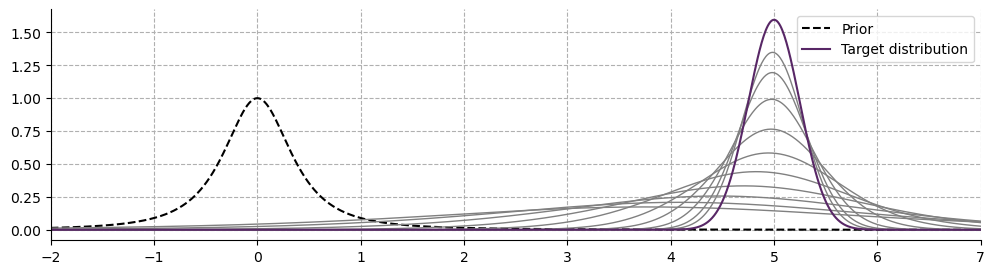

In [6]:
plt.figure(figsize=(12, 3))
plt.plot(
    x, 
    gaussian_predictive_distribution(x, xi=xi, nu=nu), 
    color="k",
    label="Prior",
    linestyle="--"
);
for i, x_i in enumerate(xs):
    xi = xi + (1/(1+nu)) * (SufficientStatistics.normal(x_i) - xi)
    nu += 1

    if i in [2, 4, 8, 16, 32, 64, 128, 256, 512, 999]:
        plt.plot(
            x, 
            gaussian_predictive_distribution(x, xi=xi, nu=nu), 
            color="grey",
            linewidth=1.0
        );
plt.plot(
    x, 
    norm.pdf(x, loc=5.0, scale=1/4), 
    color="#582766",
    label="Target distribution"
);
plt.xlim(-2, 7)
plt.legend()
plt.grid(linestyle="--");
sns.despine()

## Filtering of Sufficient Statistics for Non-stationary Input Distributions
### Using a fixed $\nu$

In [75]:
x = np.arange(0, 1000)

# create noisy input time series
xs = np.random.normal(0, 1/8, 1000)
xs[200:400] += .5
xs[600:800] -= .5

In [76]:
# initialize nu at different values
nu_1, nu_2 = 3, 20
xi_1, xi_2 = np.array([0, 1/8]), np.array([0, 1/8])

xis = []
for i, x_i in enumerate(xs):
    xi_1 = xi_1 + (1/(1+nu_1)) * (SufficientStatistics.normal(x_i) - xi_1)
    xi_2 = xi_2 + (1/(1+nu_2)) * (SufficientStatistics.normal(x_i) - xi_2)
    xis.append((xi_1, xi_2))
xis = np.asarray(xis)

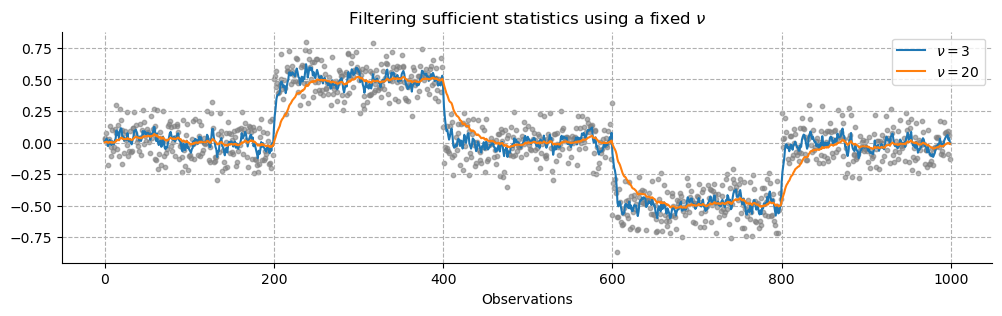

In [77]:
_, ax = plt.subplots(figsize=(12, 3))
ax.scatter(x, xs, color="grey", alpha=.6, s=10);
ax.plot(x, xis[:, 0, 0], label=rf"$\nu = {nu_1}$")
ax.plot(x, xis[:, 1, 0], label=rf"$\nu = {nu_2}$")
ax.grid(linestyle="--");
ax.set_title(r"Filtering sufficient statistics using a fixed $\nu$")
ax.set_xlabel("Observations")
ax.legend()
sns.despine()

### Filtering $\nu$ with Hierarchical Gaussian Filter

In [78]:
general_filter_hgf = (
    HGF(model_type=None)
    .add_nodes(kind="continuous-input", node_parameters={"input_precision": 100})
    .add_nodes(value_children=0, node_parameters={"tonic_volatility": -6.0})
    .add_nodes(volatility_children=[1], node_parameters={"mean": 0, "tonic_volatility": -2})
)

Initializing a network with custom node structure.


In [79]:
general_filter_hgf.set_update_sequence()
attributes = general_filter_hgf.attributes

nus = []
for i, x_i in enumerate(xs):
    mean = attributes[1]["mean"]
    
    attributes, _ = beliefs_propagation(
        edges=general_filter_hgf.edges,
        attributes=attributes,
        input_data=(x_i, [1.0], 1.0),
        input_nodes_idx=general_filter_hgf.input_nodes_idx.idx,
        update_sequence=general_filter_hgf.update_sequence,
    )

    new_mean = attributes[1]["mean"]

    nus.append(((x_i - mean) / (new_mean - mean)) - 1)

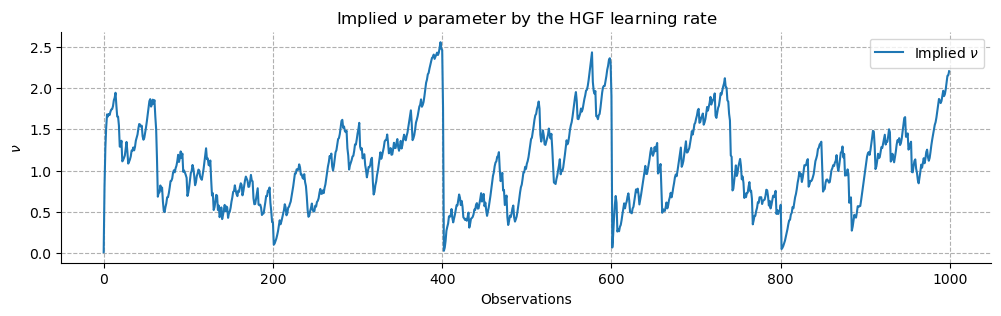

In [80]:
_, ax = plt.subplots(figsize=(12, 3))
ax.plot(x, nus, label=rf"Implied $\nu$")
ax.grid(linestyle="--");
ax.set_title(r"Implied $\nu$ parameter by the HGF learning rate")
ax.set_ylabel(r"$\nu$")
ax.set_xlabel("Observations")
ax.legend()
sns.despine()

### Filtering a bivariate normal distribution

In [143]:
# simulate a spiral data set
N = 1000
theta = np.sort(np.sqrt(np.random.rand(N)) * 5 * np.pi)
r_a = -2 * theta - np.pi
input_data = np.array([np.cos(theta)*r_a, np.sin(theta)*r_a]).T
input_data = input_data + np.random.randn(N,2) * .5

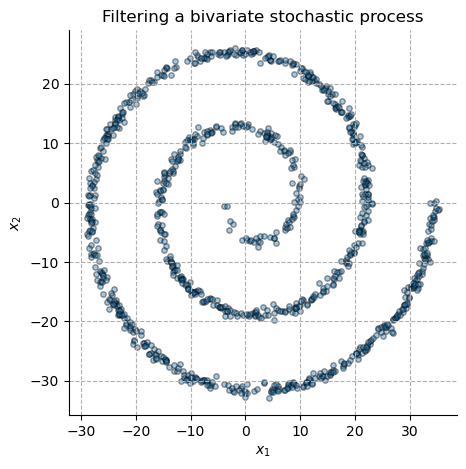

In [145]:
_, ax = plt.subplots(figsize=(5, 5))
ax.scatter(
    input_data[:,0],
    input_data[:,1],
    edgecolor="k",
    alpha=.4,
    s=15
)
ax.grid(linestyle="--");
ax.set_title(r"Filtering a bivariate stochastic process")
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$")
sns.despine()

In [146]:
sufficient_statistics = jnp.apply_along_axis(
    SufficientStatistics.multivariate_normal,
    1,
    input_data
)

In [147]:
bivariater_hgf = (
    HGF(model_type=None)
    .add_nodes(
        kind="continuous-input", 
        node_parameters={"input_precision": 100.0}, n_nodes=5
    )
)

for i in range(5):
    bivariater_hgf.add_nodes(
        value_children=i, 
        node_parameters={
            "tonic_volatility": -2.0,
            "mean": sufficient_statistics[0][i],
        }
    )

for i in range(5):
    bivariater_hgf.add_nodes(volatility_children=[i+5], node_parameters={"mean": 10, "tonic_volatility": -2})

Initializing a network with custom node structure.


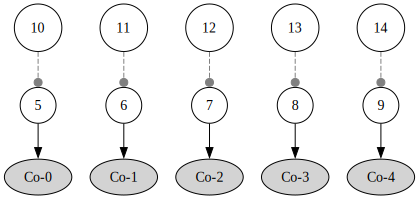

In [148]:
bivariater_hgf.plot_network()

In [164]:
bivariater_hgf.input_data(input_data=sufficient_statistics)

Adding 1000 new observations.


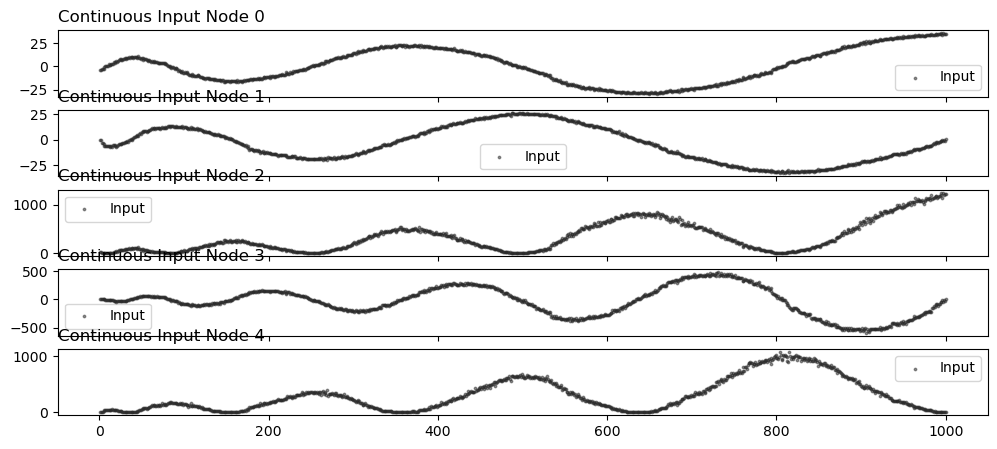

In [165]:
bivariater_hgf.plot_nodes(node_idxs=[0, 1, 2, 3, 4]);

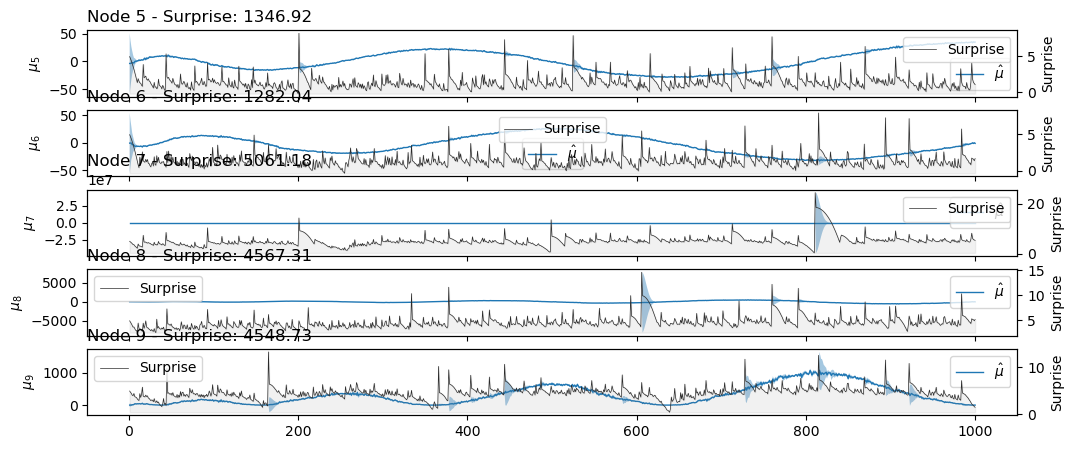

In [166]:
bivariater_hgf.plot_nodes(node_idxs=[5, 6, 7, 8, 9]);

In [151]:
general_filter_hgf.set_update_sequence()
attributes = bivariater_hgf.attributes

In [168]:
nus = []
for i in range(input_data.shape[0]):
    mean = jnp.array([attributes[i]["mean"] for i in range(5, 10)])
    
    attributes, _ = beliefs_propagation(
        edges=bivariater_hgf.edges,
        attributes=attributes,
        input_data=(sufficient_statistics[i], jnp.ones(5), jnp.ones(5)),
        input_nodes_idx=bivariater_hgf.input_nodes_idx.idx,
        update_sequence=bivariater_hgf.update_sequence,
    )

    new_mean = jnp.array([attributes[i]["mean"] for i in range(5, 10)])

    nus.append(((sufficient_statistics[i] - mean) / (new_mean - mean)) - 1)
nus = jnp.array(nus)

In [167]:
((x_i - mean) / (new_mean - mean)) - 1

Array([ 2.7299500e+03, -2.9126596e-01,  1.1693353e+03, -1.8946022e-01,
        2.0448518e-01], dtype=float32)

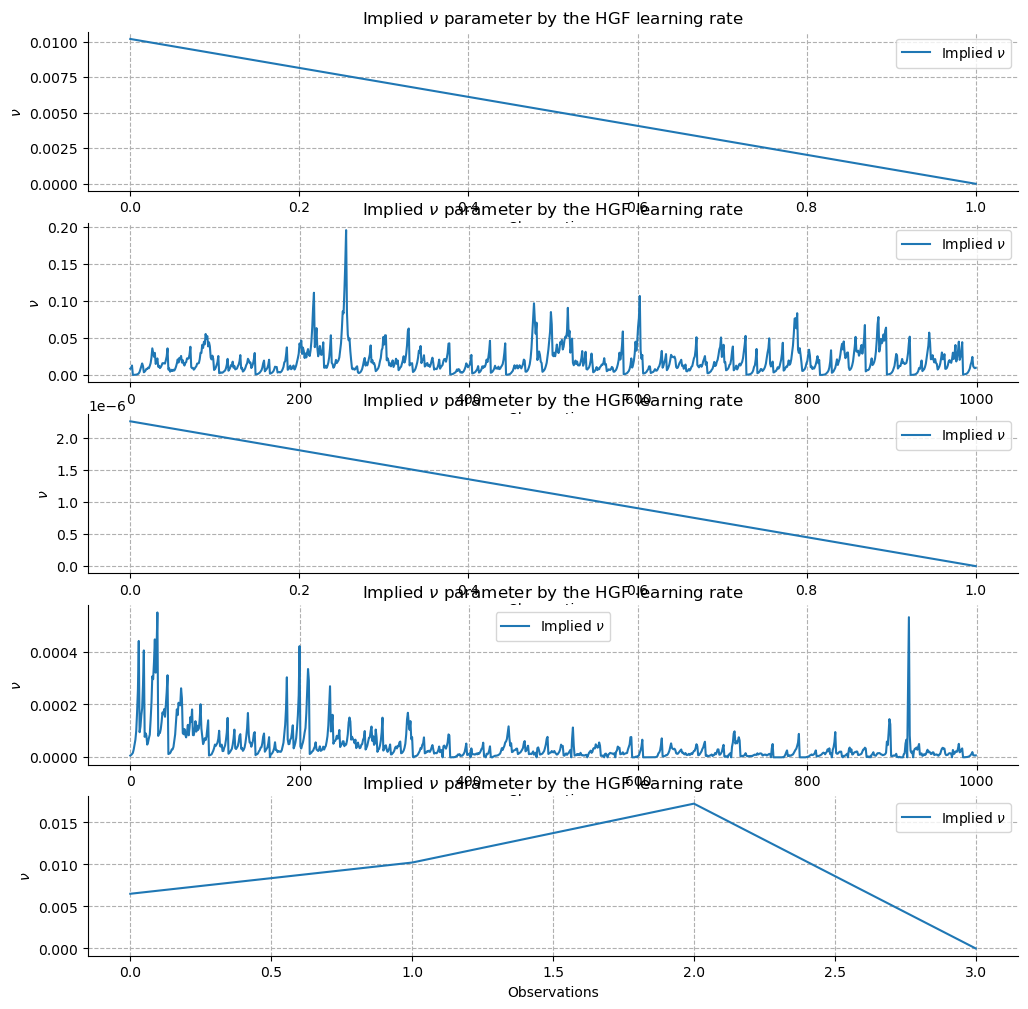

In [169]:
_, ax = plt.subplots(figsize=(12, 12), nrows=5)
for i in range(5):
    ax[i].plot(x, nus[:, i], label=rf"Implied $\nu$")
    ax[i].grid(linestyle="--");
    ax[i].set_title(r"Implied $\nu$ parameter by the HGF learning rate")
    ax[i].set_ylabel(r"$\nu$")
    ax[i].set_xlabel("Observations")
    ax[i].legend()
sns.despine()

In [154]:
input_data

array([[-3.88196576, -0.61303608],
       [-3.42387608, -0.54467878],
       [-2.29623046, -3.60972483],
       ...,
       [34.46134445, -0.06269016],
       [34.80849195, -0.99821922],
       [34.79361191,  0.22866327]])

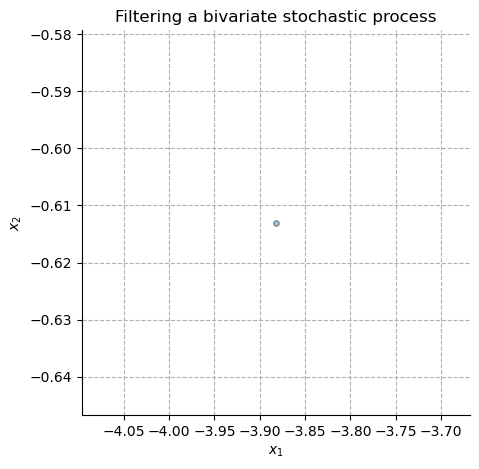

MovieWriter ffmpeg unavailable; using Pillow instead.


In [155]:
import matplotlib.animation as animation

fig, ax = plt.subplots(figsize=(5, 5))
scat = ax.scatter(
    input_data[0][0],
    input_data[0][1],
    edgecolor="k",
    alpha=.4,
    s=15
)
ax.grid(linestyle="--");
ax.set_title(r"Filtering a bivariate stochastic process")
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$")
sns.despine()


def update(frame):
    # update the scatter plot:
    scat.set_offsets(input_data[:frame])
    return scat


ani = animation.FuncAnimation(fig=fig, func=update, frames=100, interval=200)
plt.show()
ani.save("anim.gif")

# System configuration

In [156]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pyhgf,jax,jaxlib

Last updated: Wed May 01 2024

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 8.23.0

pyhgf : 0.0.16
jax   : 0.4.26
jaxlib: 0.4.26

numpy     : 1.26.0
seaborn   : 0.13.2
jax       : 0.4.26
matplotlib: 3.8.4

Watermark: 2.4.3

